# Characterizing intonation deviations in Turkish Makam music

In this notebook we provide code to download some relevant files from the [Makam Dunya corpora](https://dunya.compmusic.upf.edu/makam/) given a set of makamler, and then compute the difference in cents between the performed pitches and the theoretical pitches. This will allow us to visualize and compare these differences between Makamler. 

## Setting up the Docker image

This notebook uses CompMusic and other tools provided in the [mir-toolbox](https://hub.docker.com/r/mtgupf/mir-toolbox). Please be sure to have Docker Desktop installed and running, open this directory in a cmdline and run `docker-compose up`. Then you can run this notebook from `http://localhost:8888` using the password "**mir**".



## Getting the files from Dunya

In order to download these files you will need a Dunya API token. You can apply for one on your account page once you have created one (you can do so [here](https://dunya.compmusic.upf.edu/user/register/)). We provide a `dataset.json` file with links to a selection of recordings' data in MusicBrainz, feel free to add more makamler or recording links. 

In [2]:
# Imports - If this is already failing check the Docker image is running
import json, os, urllib, urllib.request, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import compmusic.dunya.conn
from compmusic.dunya.docserver import get_document_as_json, get_mp3
from music21 import *
import xml.etree.ElementTree as ET

In [186]:
# Setting Dunya token
token = 'insertYourTokenHere'
compmusic.dunya.conn.set_token(token)

In [8]:
# Setting path where the files will be saved to
data_folder = './data/'

# Getting the list of recordings from dataset.json
makam_recordings_list_file = './dataset.json'
makam_recordings_list = json.load(open(makam_recordings_list_file))

# Available makamler as fetched from dataset.json
makamler = list(makam_recordings_list.keys())
print("Available makamler: ")
print(makamler)


Available makamler: 
['Acemasiran', 'Acemkurdi', 'Bestenigar', 'Beyati', 'Hicaz', 'Hicazkar', 'Huseyni', 'Huzzam', 'Karcigar', 'Kurdilihicazkar', 'Mahur', 'Muhayyer', 'Neva', 'Nihavent', 'Rast', 'Saba', 'Segah', 'Sultaniyegah', 'Suzinak', 'Ussak']


In [9]:
# From the available makamler printed above, select those you want to compare.
# We selected Neva and Ussak since they have many notes in common (including the karar).
selected_makamler = ['Neva', 'Ussak']

In [ ]:
# Iterating over the recording lists of the selected makamler
for i in np.arange(len(selected_makamler)):

    # Path to makam dir and creating it if it doesn't exist
    makam_folder = os.path.join(data_folder, selected_makamler[i])
    if not os.path.exists(makam_folder):
        os.makedirs(makam_folder)

    for recording_url in makam_recordings_list[selected_makamler[i]]:

        # Getting MusicBrainz ID for the recording from the url
        recording_mbid = recording_url.split('/')[-1]

        # Trying to get metadata from recording ID, if not, ignore this recording entry
        try:
            metadata = get_document_as_json(recording_mbid, 'audioanalysis', 'metadata')
        except:
            print("Failed to get metadata from recording with ID " + recording_mbid + 
            ", makam " + selected_makamler[i])
            continue

        # Downloading note_models with information about the performed pitches and theoretical pitches
        # for each recording, skipping empty/corrupted files. These note_models come from the JointAnalyzer
        # from tomato (https://github.com/sertansenturk/tomato), trough the compmusic dunya API.
        recording_folder = os.path.join(makam_folder, recording_mbid)
        notemodels_file_path = os.path.join(recording_folder, 'note_models.json') 
        metadata_file_path = os.path.join(recording_folder, 'metadata.json') 
        if not os.path.exists(notemodels_file_path):
            try:
                note_models = get_document_as_json(recording_mbid, 'jointanalysis',"note_models")
                if len(note_models) > 0 and list(note_models.values())[0] != None:
                    if not os.path.exists(recording_folder):
                        os.makedirs(recording_folder)
                    json.dump(note_models, open(notemodels_file_path, 'w'))
                    json.dump(metadata, open(metadata_file_path, 'w'))
                    print("Fetched note_models for recording with ID " + recording_mbid + ", makam " + selected_makamler[i] + ": OK")
                #else:
                    #print("Fetched note_models for recording with ID " + recording_mbid + ", makam " + selected_makamler[i] + ": EMPTY")
            except:
                #print("Fetched note_models for recording with ID " + recording_mbid + ", makam " + selected_makamler[i] + ": FAILED")
                continue

## Notes as represented in western score notation

We download the available scores corresponding to the recordings listed in `dataset.json` to visualize the note distributions in the given makamler.  
  
For the makamler we selected, the scales are:  
Neva  
![neva-scale](img/neva.png)  
Uşşâk  
![ussak-scale](img/ussak.png)

In [189]:
# Getting list with MBIDs for works (not recordings) from SymbTr repository
symbtr_mbid_url = 'https://raw.githubusercontent.com/MTG/SymbTr/master/symbTr_mbid.json'
symbtr_mbid = json.loads(urllib.request.urlopen(symbtr_mbid_url).read())
symbtr_xml_folder = './MusicXML/'

# For each of the downloaded metadata files, we check if a score is available in the symbTr dataset, and
# if so we copy it to the recording folder.
for root, dirs, files in os.walk(data_folder):

    for f in files:
        if f == 'metadata.json':
            metadata_path = os.path.join(root, f)
            # Getting recording mbid and makam name from directory path
            recording_mbid = metadata_path.split('/')[len(metadata_path.split('/'))-2]
            makam = metadata_path.split('/')[len(metadata_path.split('/'))-3]

            # Loading metadata from file
            metadata = json.load(open(metadata_path))

            # If the recording has a work associated, search for the score and copy it to the
            # recording folder
            if 'works' in metadata.keys() and len(metadata['works']) == 1:
                work_mbid = metadata['works'][0]['mbid']
                symbtr_name = None
                for sm in symbtr_mbid:
                    if work_mbid in sm['uuid']:
                        symbtr_name = sm['name']
                if symbtr_name != None and not os.path.exists(os.path.join(root, symbtr_name + '.xml')):
                    shutil.copy(symbtr_xml_folder + symbtr_name + '.xml', root)


In [4]:
# With this dict we can map the name of the accidentals as shown in Music21 to the names of the notes as they
# appear in note_models.json (so it is easier to compare)
makam_accidentals = {'double-slash-flat':'b8' , 'flat':'b5', 'slash-flat':'b4',
'half-flat':'b4', 'quarter-flat':'b1', 'quarter-sharp':'#1', 'half-sharp':'#1', 'sharp':'#4',
'slash-quarter-sharp':'#5', 'slash-sharp':'#8'}

# Function that gets the path to a score (.xml) and returns an array of notes formatted to match note
# names as they appear in note_models.json
def get_note_array_from_score(makam_score_path):

    # Bypass key signature as it causes issues when going through the score with Music21
    tree = ET.parse(makam_score_path)
    score_root = tree.getroot()
    for attribute in score_root.iter('attributes'):
        if attribute.find('key'):
            attribute.remove(attribute.find('key'))
    new_makam_score = makam_score_path[:-4] + '--noKeySignature.xml'
    tree.write(new_makam_score)

    # Get note stream from score
    score = converter.parse(new_makam_score)
    all_notes = score.flat.notes.stream()

    # Go through all notes in score and store re-formatted name in list
    note_array = []
    for note in all_notes:
        note_name = str(note.pitch)
        if note.pitch.accidental:
            if len(note_name) == 3:
                note_name = note_name[0] + note_name[2]
            note_name = note_name + makam_accidentals[str(note.pitch.accidental.name)]
        note_array.append(note_name)
            
    # Clean up
    os.remove(new_makam_score)

    # Return note list
    return note_array

In [5]:
# Auxiliary function to help sort pandas DataFrames' notes so they appear
# in order in plots
def sort_note_list(unique_note_list):

    def note_order(note):
        note_ord = ['C', 'D', 'E', 'F', 'G', 'A', 'B']
        return note_ord.index(note)

    def accidental_order(full_note):
        if len(full_note) == 2:
            full_note += '00'
        accidental_order = ['b8', 'b5', 'b4', 'b1', '00', '#1', '#4', '#5', '#8']
        return accidental_order.index(full_note[2:])

    sorted_note_list = unique_note_list
    
    sorted_note_list.sort(key=lambda x:accidental_order(x))
    sorted_note_list.sort(key=lambda x:note_order(x[0]))
    sorted_note_list.sort(key=lambda x:x[1])

    return sorted_note_list

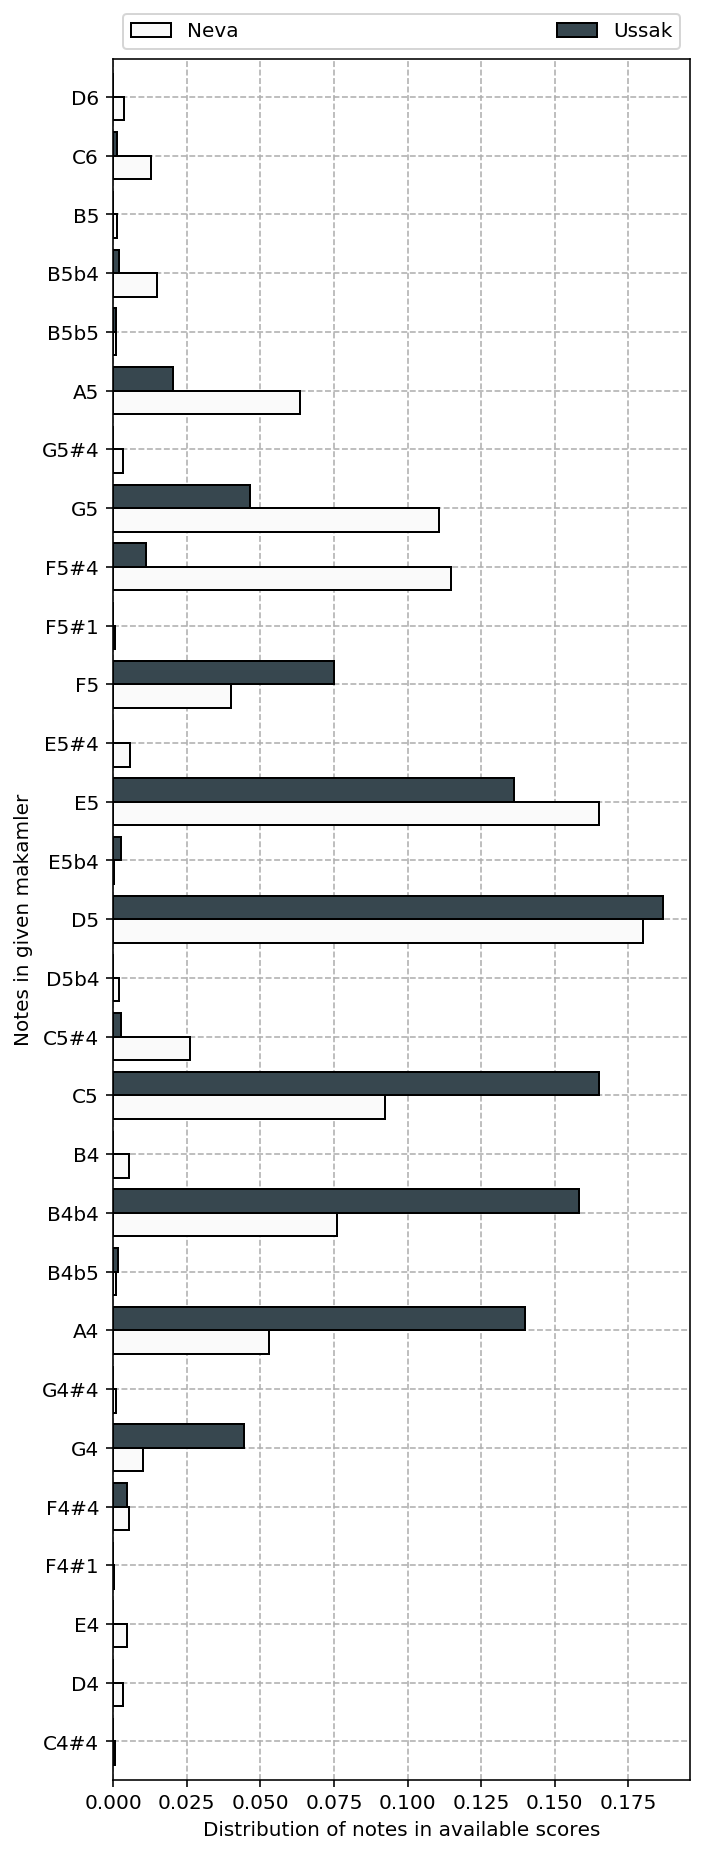

In [192]:
# Going through the scores and storing the note lists in a DataFrame
note_counts_df = pd.DataFrame()
for makam in selected_makamler:
    notes_in_makam_from_scores = []
    for root, dirs, files in os.walk(os.path.join(data_folder, makam)):
        for f in files:
            if f.endswith('xml'):
                filepath = os.path.join(root, f)
                makam = filepath.split('/')[len(filepath.split('/'))-3]
                notes_in_makam_from_scores.extend(get_note_array_from_score(filepath))

    note_counts_df_makam = pd.DataFrame(pd.Series(notes_in_makam_from_scores).value_counts()).rename(columns={0: makam})
    note_counts_df[makam] = note_counts_df_makam[makam]

# Sort DataFrame by notes and normalize to obtain distribution from note counts
note_counts_df = note_counts_df.transpose()
note_counts_df = note_counts_df[sort_note_list(list(note_counts_df.columns.to_list()))].transpose()
note_counts_df_normalized = note_counts_df[note_counts_df.columns.to_list()]/note_counts_df[note_counts_df.columns.to_list()].sum()

# Plot distributions
ax1 = note_counts_df_normalized.plot(kind='barh', figsize=(5,13), width=0.8,
    color=greyscale_colors[0:len(list(note_counts_df_normalized.columns.to_list()))], edgecolor="black")
ax1.set_xlabel('Distribution of notes in available scores'), ax1.set_ylabel('Notes in given makamler'), 
ax1.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=2)
ax1.set_axisbelow(True)
ax1.grid(ls='--')
fig = ax1.get_figure()
fig.tight_layout()
fig.savefig('score_notes.png', dpi=300)

## Plotting differences between performed (stable) pitch and theoretical pitch

From the previously downloaded note models we can plot the differences between the performed pitches and, taking the karar as reference, the pitch according to the theoretical interval. This will allow us to see how much the same pitches in notation differ in intonation when performed.

In [10]:
# First we want to retrieve the information from note_models and store it in DataFrames per recording

# Format DataFrame to display uniform number of decimals
pd.options.display.float_format = "{:,.2f}".format


# Iterate through the selected makamler
makamler_dfs = {} 
for makam in selected_makamler:
    makam_path = os.path.join(data_folder,makam)    
    makamler_dfs[makam] = []

    # Get mbids
    mbids = os.listdir(makam_path)

    # For each recording, load note_models.json
    for mbid in mbids:
        path = os.path.join(makam_path,mbid)
        note_models_file = os.path.join(path,'note_models.json')

        if os.path.exists(note_models_file):

            with open(note_models_file) as f:
                note_models_data = json.load(f)
                new_dict = {}

                # Some note_models.json are formatted a bit differently (more/less node levels) these lines bypass that
                if len(note_models_data) == 1:
                    if list(note_models_data.values())[0] == None:
                        continue
                    note_models_data = list(note_models_data.values())[0]

                # Retrieve values and add to DataFrame
                for note in note_models_data:
                    new_dict[note] = { "stable_pitch":note_models_data[note]["stable_pitch"]["value"], "theoretical_pitch":note_models_data[note]["theoretical_pitch"]["value"]}
                df = pd.DataFrame.from_dict(new_dict)
                makamler_dfs[makam].append({mbid: df})

# Display DataFrame for each recording with stable pitch and theoretical pitch. Commented because it's very long,
# uncomment it if you want to check them out.
#for mk in makamler_dfs:
#    for rec in makamler_dfs[mk]:
#        rec_name = list(rec.keys())[0]
#        print(rec_name)
#        display(rec[rec_name])

In [6]:
# Auxiliary function to calculate the cents between two given frequencies
def hz_to_cents(f1, f2):
    cents = np.round(1200.0 * np.log2(f2 / f1), 1)
    if cents == 0:
        cents = abs(cents)
    return cents

In [11]:
# Computing the difference in cents from stable pitch to theoretical pitch and
# joining all recordings in one big beautiful DataFrame per Makam

# Format display to 1 decimal
pd.options.display.float_format = "{:,.1f}".format

# Get a dict the makamles as keys and a set of unique performed note labels for each
unique_notes_per_makam = {}
for makam_key in makamler_dfs:
    unique_notes_per_makam[makam_key] = []
    for recording_dict in makamler_dfs[makam_key]:
        notes = recording_dict[list(recording_dict.keys())[0]].columns.tolist()
        unique_notes_per_makam[makam_key].extend(notes)
    aux_set = set(unique_notes_per_makam[makam_key])
    unique_notes_per_makam[makam_key] = aux_set


# Calculating cents for each recording (f1 = theoretical pitch, f2 = stable pitch)
makamler_dfs_diff_pitch = {}
for makam_key in makamler_dfs:
    makamler_dfs_diff_pitch[makam_key] = []
    for recording in makamler_dfs[makam_key]:
        
        # Building up data structure
        recording_name = list(recording.keys())[0]
        new_dict = {recording_name: recording[recording_name].copy()}
        notes_in_makam = new_dict[recording_name].columns.tolist()
        ser = pd.Series(data=np.zeros(len(notes_in_makam)), index=notes_in_makam)

        # Calculating the difference in cents between theoretical and stable pitches
        for note_name in new_dict[recording_name].loc['stable_pitch'].keys():
            f1 = new_dict[recording_name].loc['theoretical_pitch'][note_name]
            f2 = new_dict[recording_name].loc['stable_pitch'][note_name]
            ser[note_name] = hz_to_cents(f1, f2)

        # Appending to data structure
        new_dict[recording_name].loc['cents'] = ser
        new_dict[recording_name] = new_dict[recording_name].drop(["stable_pitch", "theoretical_pitch"])
        makamler_dfs_diff_pitch[makam_key].append(new_dict)


# Moving from 1 DataFrame per recording to 1 DataFrame per Makam, keeping MBID as index
makamler_cents_dfs = {}
for makam_key in makamler_dfs_diff_pitch:
    makamler_cents_dfs[makam_key] = pd.DataFrame(columns=unique_notes_per_makam[makam_key])
    for i in range(len(makamler_dfs_diff_pitch[makam_key])):
        recording_name = list(makamler_dfs_diff_pitch[makam_key][i].keys())[0]

        # Creating auxiliary DataFrame to change labels and reformat a bit
        df_aux = makamler_dfs_diff_pitch[makam_key][i][recording_name].copy()
        df_aux = df_aux.rename(index={'cents': recording_name})
        cols = df_aux.columns.tolist()
        for unique_note in unique_notes_per_makam[makam_key]:
            if unique_note not in cols:
                df_aux.insert(0, unique_note, '-')
        
        # Appending auxiliary DataFrame to data structure
        makamler_cents_dfs[makam_key] = pd.concat([makamler_cents_dfs[makam_key], df_aux], sort=True)

# Display all columns in DataFrame when printing
pd.set_option('display.max_columns', None)

# Sorting note columns and displaying DataFrames
for mk in makamler_cents_dfs:
    makamler_cents_dfs[mk] = makamler_cents_dfs[mk][sort_note_list(list(unique_notes_per_makam[mk]))]
    makamler_cents_dfs[mk] = makamler_cents_dfs[mk].replace(np.nan, '-').round(1)
    print((' ' + str.upper(mk) + ' ').center(100, '_'))
    display(makamler_cents_dfs[mk])       

_______________________________________________ NEVA _______________________________________________


,C4#4,D4,E4,F4#1,F4#4,G4,G4#4,A4,B4b5,B4b4,B4b1,B4,C5,C5#4,D5b4,D5,E5b4,E5b1,E5,F5,F5#1,F5#4,G5,G5#4,A5,B5b5,B5b1,B5,C6,D6
015f963c-18f6-4285-9cad-f2a3fb9ca46c,-,-,-,-,-,-10.0,5.0,0.0,-,-,0.5,2.5,-7.5,31.0,-,2.5,-,-,-2.5,-5.0,-,-3.0,-10.0,44.5,22.5,-,-19.5,32.5,-15.0,-
0a4e0d9e-d11f-4e33-bf8b-1fa6a42db048,-,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,17.5,-,-,-,-,-,-,-,-,-7.5,-,-,-,-,-
132cb194-c083-4002-9cc9-720b8cbfc61c,-,-,-,-,-,-,-,0.0,-,-,0.5,-,0.0,16.0,-,-5.0,-,-,-2.5,-,-,-3.0,-2.5,-,-7.5,-,18.0,-,-7.5,-5.0
2837c013-af26-431c-a4d8-34e89e0555f4,-,-,-,-,-,-17.5,-,0.0,-,-,-7.0,-,-7.5,23.5,-,-12.5,-,-,12.5,-20.0,-,-18.0,-17.5,-,0.0,-,10.5,-,-,-
2e87a363-838e-4565-bf2a-ae45ffb691ff,-,-,-,-,-,-,27.5,0.0,-,-,0.5,-,-,-6.5,-,-5.0,-,-,5.0,2.5,-,-10.5,-10.0,14.5,-7.5,-,-,2.5,-,-
50c24abc-b6c9-4f5f-840e-479f5917ebcd,-,-,-,-,-,-10.0,-2.5,0.0,-,-,0.5,-12.5,-15.0,-6.5,-,-5.0,-,-,-2.5,-5.0,-,-3.0,-10.0,-0.5,0.0,-,-19.5,-5.0,-,-
652c3919-a1f3-41ea-9a2f-b1e0fbb0f6c6,-,-,-,-,-,-10.0,27.5,0.0,-,-13.0,0.5,2.5,-7.5,1.0,-,-5.0,-,-,5.0,-5.0,-,-3.0,-2.5,-,15.0,-,-,-,-,-
6661b6f2-a306-4c77-8c16-a44870e17bc4,-,-,-,-,-,-10.0,-10.0,0.0,-,2.0,-22.0,-,-7.5,1.0,-,2.5,-,-,5.0,-5.0,-,4.5,-2.5,-,7.5,-,-,-,-,-
89df4e91-0124-401a-996e-e88b3d7aac3b,-,-,-,-,-,-,-,0.0,-,-,0.5,-,-7.5,1.0,-,-5.0,-,-,-2.5,10.0,-,-10.5,-2.5,-,7.5,-,-,-,-,-
8ca7ed06-d505-455d-8136-e5e12b1cb1a9,-,-5.0,27.5,-16.5,-,-2.5,27.5,0.0,-,9.5,0.5,-,-7.5,-6.5,42.0,10.0,-,-,5.0,10.0,-18.5,-3.0,5.0,37.0,15.0,-,-4.5,25.0,22.5,-


______________________________________________ USSAK _______________________________________________


,F4#4,G4,A4,A4#4,B4b5,B4b4,B4b1,C5,C5#4,D5,E5b4,E5b1,E5,F5,F5#4,G5,A5,B5b5,B5b4,B5b1,C6
03faad43-689e-4814-93ad-b7f678531e5f,6.5,5.0,0.0,-,-,-,-14.5,0.0,-,2.5,44.5,-,12.5,2.5,-18.0,12.5,15.0,4.0,-,-,-
32e029de-8550-4bc6-ac8b-df55e8ba456e,-16.0,-10.0,0.0,-,-,39.5,-37.0,-7.5,-,-5.0,14.5,-,5.0,-12.5,-3.0,-2.5,0.0,-,-,-,-
64ab7fb3-e754-4121-b25f-02bedf331380,-,-2.5,0.0,-,-,-,-37.0,-7.5,-,-5.0,-,-,12.5,-12.5,-3.0,-10.0,0.0,-,-,10.5,-15.0
6e220f2d-fbcf-4f8b-a961-9c7f73c623d7,44.0,-2.5,0.0,-,-,-,-29.5,-7.5,-,-5.0,-,-,-2.5,-,-,-2.5,-,-,-,-,-
80b42df4-e113-4084-8b25-e33eb7ee4aa6,-,5.0,0.0,32.0,-,-,-7.0,-15.0,-36.5,2.5,-0.5,6.5,-2.5,2.5,-33.0,-10.0,0.0,-,41.0,-34.5,-30.0
92ef6776-09fa-41be-8661-025f9b33be4f,-,-,0.0,-,-,-,-14.5,-22.5,-,-5.0,-,-,-2.5,-20.0,-10.5,-2.5,-7.5,-,-,-19.5,-37.5
995cbbb4-2bf1-4f1c-8e35-f4467b22afac,-,-10.0,0.0,-,-,17.0,-22.0,0.0,-6.5,2.5,-,-,12.5,2.5,-,-10.0,0.0,-,-,-,-
99d17fb7-9ff6-4d16-8742-4244a870cdae,-23.5,-2.5,0.0,-,9.0,-,-44.5,-7.5,-,10.0,-,-,5.0,-20.0,-25.5,-2.5,0.0,-,-,-,-
c4b8b080-dbe0-45d3-b12c-798a57a2813f,-,-10.0,0.0,-,-,17.0,-7.0,-7.5,-6.5,2.5,-,-,5.0,-5.0,-,-17.5,-15.0,-,-,-,-
cca7ba0a-9614-449d-b73e-ac761f270c63,-1.0,-17.5,0.0,-,-,-,-37.0,-15.0,-,2.5,-,-,12.5,-5.0,-,-2.5,0.0,-,-,-,-


In [53]:
# Since these differences also vary per Makam, an easier way to visualize them could be to calculate the mean of the difference
# per note and the standard deviation.

# Changing format to display 1 decimal
pd.options.display.float_format = "{:,.1f}".format

# Iterate through makamler
mean_std_dev = {}
for mk in makamler_cents_dfs:

    mean_std_dev[mk] = pd.DataFrame(columns=makamler_cents_dfs[mk].columns.tolist())

    # Calculating mean
    mean_df = pd.DataFrame(makamler_cents_dfs[mk].replace('-', np.nan).mean()).transpose().rename(index={0: 'mean'})

    # Calculating standard deviation
    std_dev_df = pd.DataFrame(makamler_cents_dfs[mk].replace('-', np.nan).std()).transpose().replace(np.nan, '-').rename(index={0: 'std_dev'})
    
    # Number of notes used in these calculations (since e.g., the standar deviation for a note that only has one occurence
    # will not be meaningful)
    n_notes_df = pd.DataFrame(makamler_cents_dfs[mk].replace('-', np.nan).notna().sum()).transpose().rename(index={0: 'n_notes'}).replace(True, 1.0)
    uninteresting_columns = n_notes_df.columns[(n_notes_df < 5.0).iloc[0]].to_list()

    mean_df = mean_df.drop(uninteresting_columns, axis=1)
    std_dev_df = std_dev_df.drop(uninteresting_columns, axis=1)
    n_notes_df = n_notes_df.drop(uninteresting_columns, axis=1)

    # Append data
    mean_std_dev[mk] = pd.concat([mean_df.round(1), std_dev_df.round(1), n_notes_df.round(0)])

    # Display
    print((' ' + str.upper(mk) + ' ').center(100, '_'))
    display(mean_std_dev[mk])

_______________________________________________ NEVA _______________________________________________


,G4,G4#4,A4,B4b4,B4b1,B4,C5,C5#4,D5,E5,F5,F5#4,G5,G5#4,A5,B5b1,B5,C6
mean,-10.5,18.3,0.0,0.9,-0.8,-3.9,-7.5,5.0,0.1,2.5,-2.2,-6.3,-5.4,14.5,3.8,-4.5,7.9,-5.0
std_dev,6.9,16.7,0.0,8.0,9.0,5.2,7.0,13.6,7.9,8.1,9.4,9.0,6.4,19.4,9.0,15.0,16.0,16.3
n_notes,14.0,9.0,19.0,7.0,18.0,7.0,17.0,17.0,19.0,18.0,16.0,18.0,18.0,7.0,18.0,10.0,7.0,9.0


______________________________________________ USSAK _______________________________________________


,F4#4,G4,A4,B4b1,C5,D5,E5,F5,F5#4,G5,A5,B5b1,C6
mean,4.0,-5.9,0.0,-22.5,-8.6,0.8,6.9,-7.0,-13.3,-5.0,-0.7,-1.5,-13.5
std_dev,24.0,7.8,0.0,12.6,6.5,4.5,6.5,8.3,11.3,7.4,7.1,26.3,21.5
n_notes,6.0,11.0,14.0,14.0,14.0,13.0,12.0,11.0,8.0,12.0,11.0,5.0,5.0


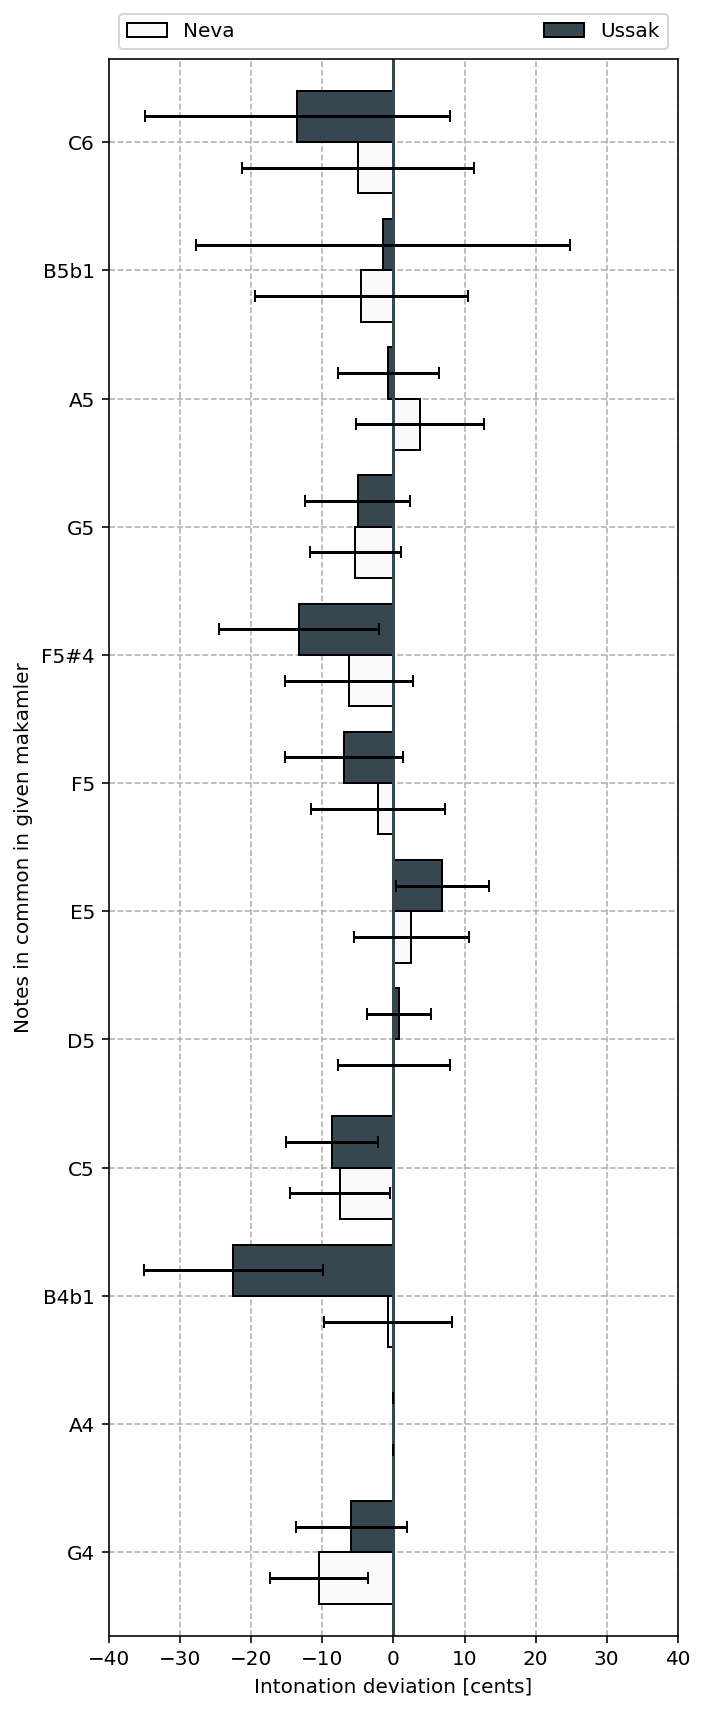

In [62]:
# Let's plot!

# Reformatting data structure to make plotting easier
mean_std_dev_comb_df = pd.DataFrame()
for mk in mean_std_dev:
    mean_std_dev_comb_df[mk] = mean_std_dev[mk].loc['mean',:]
for mk in mean_std_dev:
    mean_std_dev_comb_df['std_dev ' + mk] = mean_std_dev[mk].loc['std_dev',:]

# Plotting
n_makams = len(mean_std_dev)
greyscale_colors=["#fafafa", "#37474f", "#cfd8dc", "#455a64"]
mean_std_dev_comb_df = mean_std_dev_comb_df.dropna().replace('-', 0.0)
ax = mean_std_dev_comb_df.plot(kind='barh', y=mean_std_dev_comb_df.iloc[:,0:n_makams].columns.to_list(), xerr=mean_std_dev_comb_df.iloc[:,n_makams:].values.T,
    capsize=3, figsize=(5,12), width=0.8, color=greyscale_colors[0:n_makams], edgecolor="black")
ax.set_xlabel('Intonation deviation [cents]'), ax.set_ylabel('Notes in common in given makamler'), 
ax.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=2)
ax.set_axisbelow(True)
ax.axvline(0, color=greyscale_colors[1], zorder=1), ax.set_xlim(-40, 40)
ax.grid(ls='--', zorder=0)
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('mean_stddev_cents.png', dpi=300)


## Thank you for trying out our code!
  
![horon-kemence](img/horon_kemence.gif)  
  
  Please feel free to contact us on GitHub or open an issue if something is not working as it should.  
